In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

In [20]:
vid = np.load("sample_capture.npy")
vid.shape

(100, 480, 640, 3)

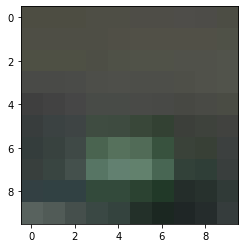

In [68]:
frame = vid[10]
plt.imshow(cv2.cvtColor(frame[120:130,205:215], cv2.COLOR_BGR2RGB))

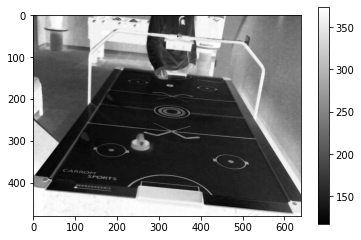

In [69]:
#target = np.array([0,128,255]) # orange
#target = np.array([30,220,85]) # green
target = np.array([255,100,255]) # pink

dist = np.linalg.norm(target-frame, axis=2)

plt.imshow(dist, cmap='gray')
plt.colorbar()

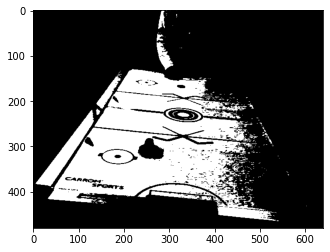

In [70]:
thresh = np.min(dist) + 30
mask = dist < thresh
plt.imshow(mask, cmap='gray')

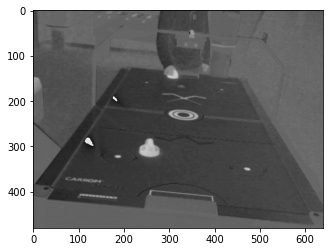

In [33]:
target = np.array([0,128,255])
dist = np.linalg.norm(target-frame, axis=2)

plt.imshow(dist, cmap='gray')
plt.colorbar()

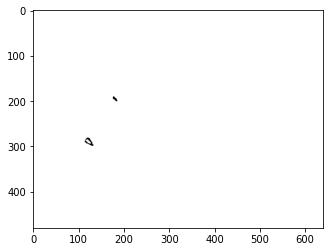

In [34]:
thresh = np.max(orange_frame) - 30
mask = orange_frame < thresh
plt.imshow(mask, cmap='gray')

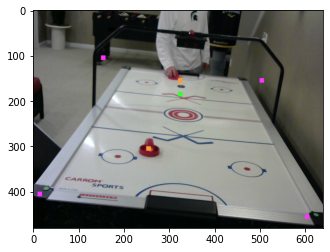

In [74]:
def add_box(image, target, loc, s=10):
    for x in range(loc[0], loc[0]+s):
        for y in range(loc[1], loc[1]+s):
            image[x,y] = target
    return image
            
green = np.array([51,255,51])
violet = np.array([255,51,255])
orange = np.array([51,153,255])

frame = add_box(frame, green, (180,320)) # puck
frame = add_box(frame, orange, (150,320)) # strikers
frame = add_box(frame, orange, (300,250))
frame = add_box(frame, violet, (100,150)) # corners
frame = add_box(frame, violet, (150,500))
frame = add_box(frame, violet, (400,10))
frame = add_box(frame, violet, (450,600))

plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

Testing color_mask(), find_centroids(), set_corners()

[[604 454]
 [ 14 404]
 [504 154]
 [154 104]]


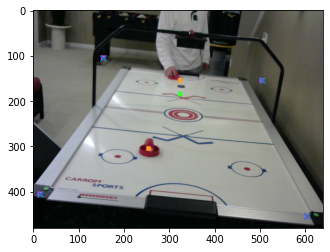

In [94]:
def color_mask(img, color, thresh=10):
    """
    Mask image according to color
    :return: mask (0:other colors, 1:selected color)
    """
    dist = np.linalg.norm(img-color, axis=2)
    mask = dist <= thresh
    return np.float32(mask)

def find_centroids(img, n=1):
    """
    Detect n largest contours of mask and find centers
    If no objects detected, return center of table
    :return: size sorted centriod list
    """
    rescaled_dim = (270, 150)
    
    # Find contours
    contours = cv2.findContours(np.uint8(img), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # Get centers and areas
    centers = []
    areas = []
    for c in contours:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers.append([cX,cY])
        areas.append(cv2.contourArea(c))

    # Make sure we have enough contours
    while len(areas)<n:
        centers.append([rescaled_dim[1]/2, rescaled_dim[0]/2])
        areas.append(0)

    # Find top n sorted contours
    sorted_centers = []
    for i in np.argsort(-1*np.array(areas))[:n]:
        sorted_centers.append(centers[i])

    return np.array(sorted_centers)

corner_mask = color_mask(np.float32(frame), violet)
pts = find_centroids(corner_mask, 4)
print(pts)

# put pts in correct order
corners = np.zeros((4, 2))
s = pts.sum(axis = 1)
corners[0] = pts[np.argmin(s)]
corners[2] = pts[np.argmax(s)]
diff = np.diff(pts, axis = 1)
corners[1] = pts[np.argmin(diff)]
corners[3] = pts[np.argmax(diff)]

plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
plt.scatter(corners[:,0],corners[:,1], marker='x')
plt.show()

Testing perspective_shift()

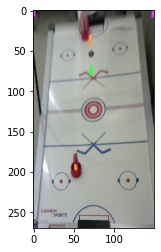

In [98]:
rescaled_dim = (150, 270)

dst = np.array([[0, 0],
                [rescaled_dim[0]-1, 0],
                [rescaled_dim[0]-1, rescaled_dim[1]-1],
                [0, rescaled_dim[1]-1]])
# compute the perspective transform matrix and then apply it
M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(dst))
warped = cv2.warpPerspective(frame, M, rescaled_dim)

plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))

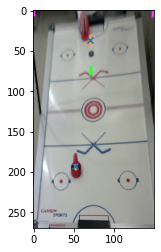

In [100]:
mask = color_mask(np.float32(warped), orange)
pts = find_centroids(mask, 2)

plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
plt.scatter(pts[:,0],pts[:,1], marker='x')
plt.show()

Testing get_pos()

In [101]:
loc = pts[0]
table_length = 2.7
table_width = 1.5
pos_y = (table_length/rescaled_dim[1])*(loc[0]-rescaled_dim[1]/2)
pos_x = (table_width/rescaled_dim[0])*(loc[1]-rescaled_dim[0]/2)
print(pos_x, pos_y)

-0.39 -0.65
